In [8]:
import pandas as pd
import gc
import time
from contextlib import contextmanager
import custom_kernel as ckk
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, roc_curve, auc, recall_score
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# MLFLOW
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

import utilitaires_810 as gu810

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

GIT_FOLDER = './'
DOSSIER_IMG = GIT_FOLDER+'temp_img/'
INPUT_FOLDER = GIT_FOLDER + 'processed_data/'
TEST_SIZE = 0.3
RANDOM_STATE = 42

# 0. Load Data et Split Test & Train

In [2]:
df = pd.read_csv(INPUT_FOLDER+'kernel03_install_payments.csv')

In [3]:
df = ckk.reduce_memory(df)

Initial df memory usage is 1454.12 MB for 535 columns
Final memory usage is: 475.65 MB - decreased by 67.3%


In [4]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

X = train_df.drop(columns = ['TARGET'])
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Train shape: (307506, 535), test shape: (48744, 535)
X_train : (215254, 534) // X_test : (92252, 534)
y_train : (215254,) // y_test : (92252,)


# 1. Define Custom Metric

In [4]:
# ---------------------------------------------------------------- MAKE SCRORER
def custom_metric(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.2 * faux_pos + 0.8 * faux_negs)
    return f2_score

custom_score = make_scorer(custom_metric, greater_is_better=True)

# 2. Pipeline functions to create model

In [16]:
s_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
ss_scaler = StandardScaler()
mm_scaler = MinMaxScaler(feature_range=(0,1))
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(penalty='l2', solver='lbfgs', class_weight='balanced')

In [17]:
imputer = s_imputer
scaler = ss_scaler
oversampler = over
undersampler = under

model_1 = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model_1.fit(X_train, y_train)

model_1

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', LogisticRegression(class_weight='balanced'))])

# 3. Train, test and save score

 TRAIN F2 score model :  0.44347146320122777


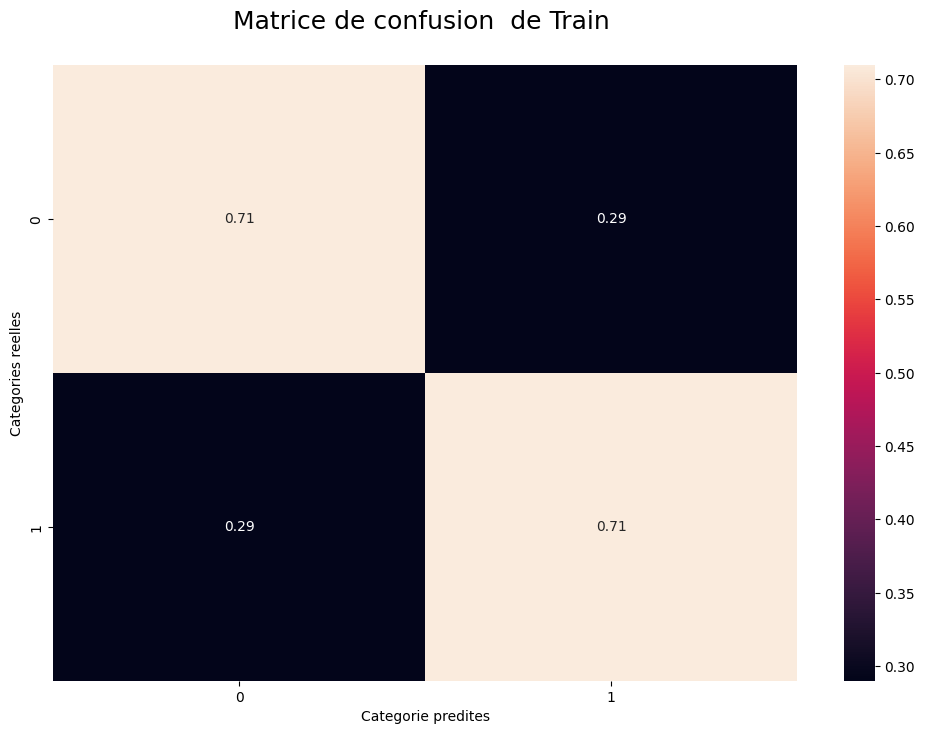

F2 score model 1 :  0.43556955873234005


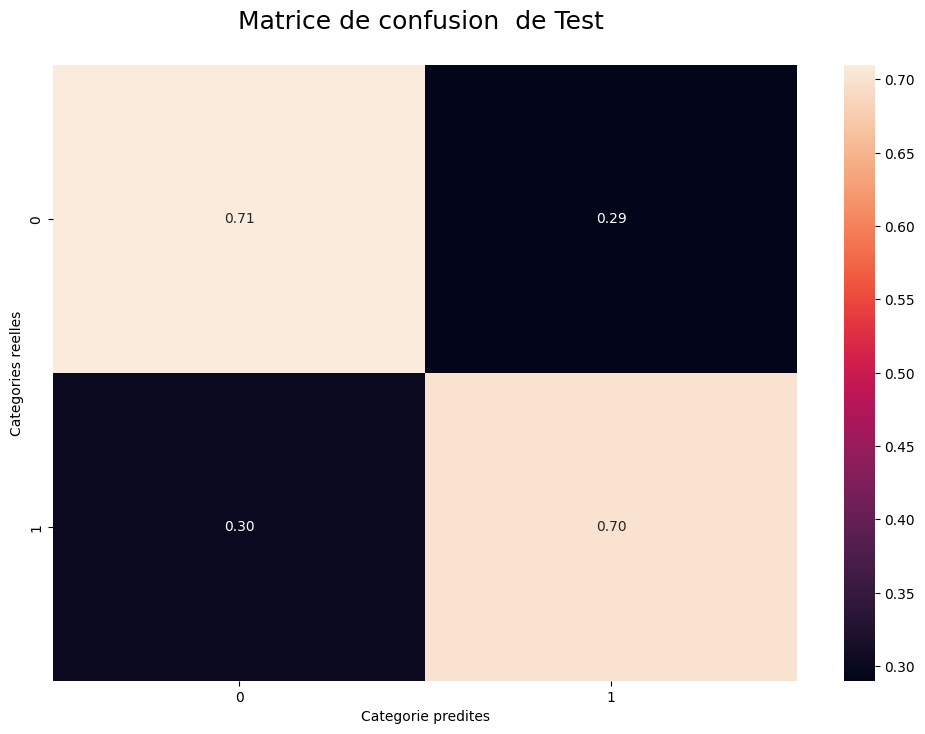

In [18]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(oversampler))
    mlflow.log_param("under-sampler", str(undersampler))
    y_pred = model_1.predict(X_test)
    y_train_pred = model_1.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = gu810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = gu810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [6]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = MinMaxScaler(feature_range=(0,1))
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(penalty='l2', solver='lbfgs', class_weight='balanced')

pipeline = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

params = {
    'estimator__penalty' : ['l1', 'l2', 'elasticnet'],
    'estimator__max_iter' : [100, 200, 500]
}

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', MinMaxScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'estimator__max_iter': [100, 200, 500],
                         'estimator__penalty': ['l1', 'l2', 'elasticnet']},
             return_train_score=True, scoring=make_scorer(custom_metric))

If I increase the x2 feature by w2, the predictions var

In [7]:
print("Best params : ", model.best_params_)
print("Best score : ", model.best_score_ )

Best params :  {'estimator__max_iter': 200, 'estimator__penalty': 'l2'}
Best score :  0.4350512657951443


/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 TRAIN F2 score model :  0.43929196682260424


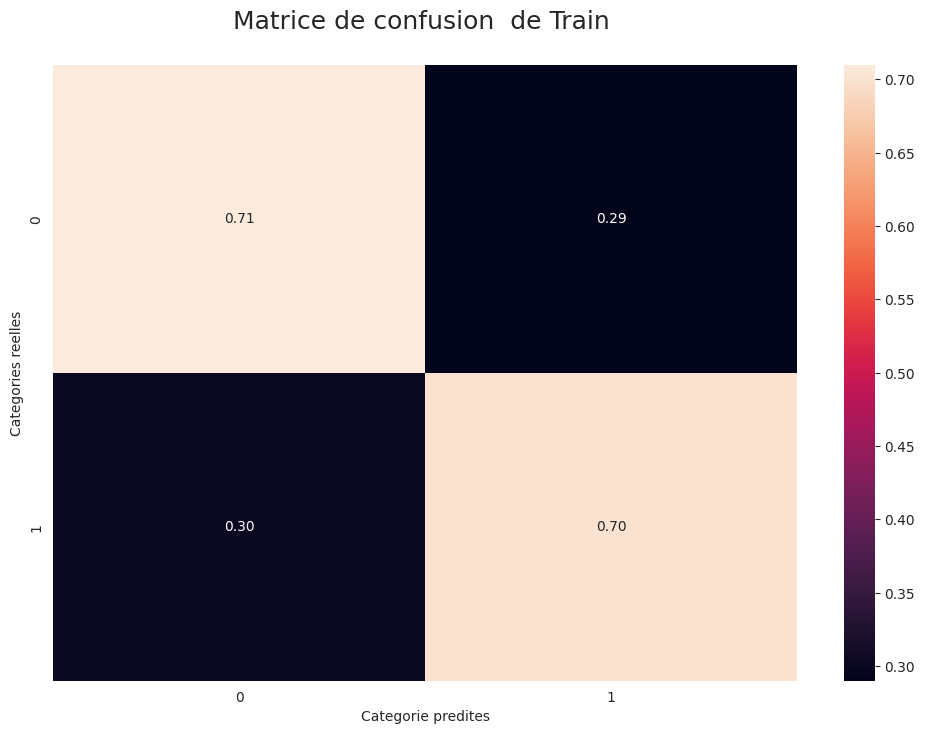

F2 score model 1 :  0.43613236676063893


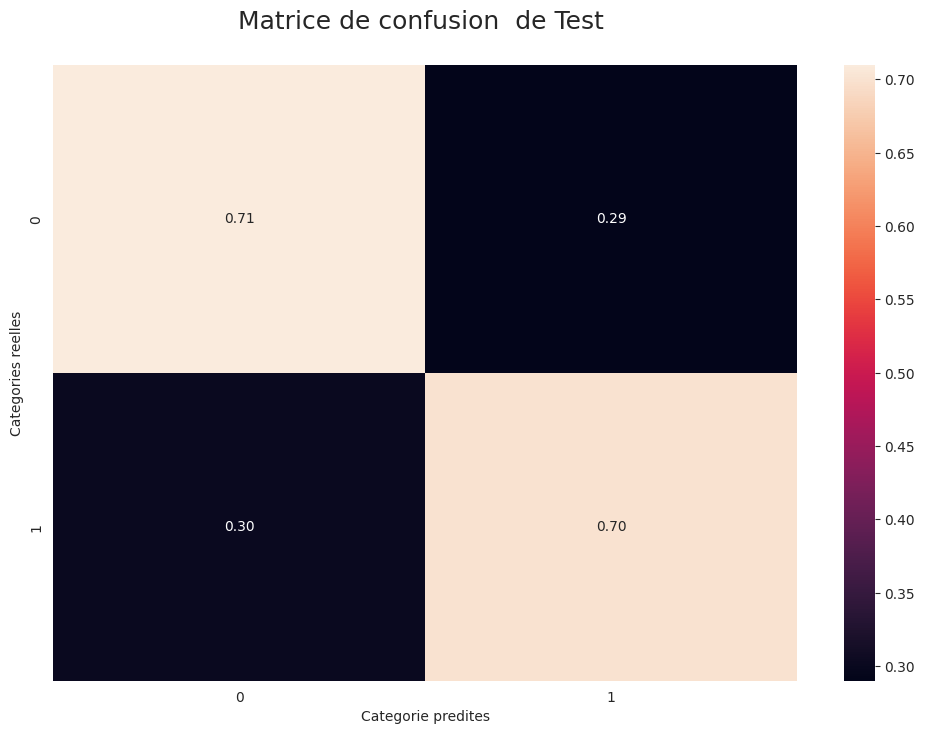

In [11]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = MinMaxScaler(feature_range=(0,1))
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=200)

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

with mlflow.start_run():
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = gu810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = gu810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [12]:
X_imputed = imputer.fit_transform(X_train)
X_scaled = scaler.fit_transform(X_imputed)
X_over, y_over = over.fit_resample(X_scaled, y_train)
X_under, y_under = under.fit_resample(X_over, y_over)

# t-SNE
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, init='pca')

X_trans = tsne.fit_transform(X_under)

In [16]:
X_preprocessed = pd.DataFrame(X_under, columns=X.columns)
X_preprocessed.head(2)

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INS_48M_LIMIT_USE_MEAN,CURRENT_TO_APPROVED_CREDIT_MIN_RATIO,CURRENT_TO_APPROVED_CREDIT_MAX_RATIO,CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO,CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED
0,0.363409,0.363907,0.0,1.0,0.013594,0.185301,0.190400,0.158427,0.344390,0.568079,...,0.097019,0.003458,0.001688,0.003732,0.006708,0.009022,0.27072,0.174190,0.444059,0.001469
1,0.387409,0.387747,1.0,0.0,0.004582,0.008955,0.018603,0.005618,0.158039,0.744815,...,0.152113,0.052014,0.018332,0.048020,0.053237,0.093415,0.16012,0.176736,0.169756,0.000279


In [21]:
logreg_on_preprocessed_data = LogisticRegression(penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=200).fit(X_under, y_under)
y_train_pred = logreg_on_preprocessed_data.predict(X_under)

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
fpr, tpr, thresholds = roc_curve(y_under, y_train_pred)
test_auc_score = auc(fpr, tpr)
test_F2_score = custom_metric(y_true=y_under, y_pred=y_train_pred)
test_rappel = recall_score(y_true=y_under, y_pred=y_train_pred)
print("train_auc_score : ", test_auc_score)
print("train_F2_score : ", test_F2_score)
print("train_rappel : ",test_rappel)

train_auc_score :  0.7105549097892555
train_F2_score :  0.6713086863434776
train_rappel :  0.7099105473290545


In [24]:
df_synthese = X_preprocessed
df_synthese['y_train'] = y_under
df_synthese['y_train_pred'] = y_train_pred
df_synthese.loc[(df_synthese['y_train'] == 1) & (df_synthese['y_train_pred'] == 0), 'Cat_class'] = "FN"
df_synthese.loc[(df_synthese['y_train'] == 1) & (df_synthese['y_train_pred'] == 1), 'Cat_class'] = "TP"
df_synthese.loc[(df_synthese['y_train'] == 0) & (df_synthese['y_train_pred'] == 0), 'Cat_class'] = "TN"
df_synthese.loc[(df_synthese['y_train'] == 0) & (df_synthese['y_train_pred'] == 1), 'Cat_class'] = "FP"

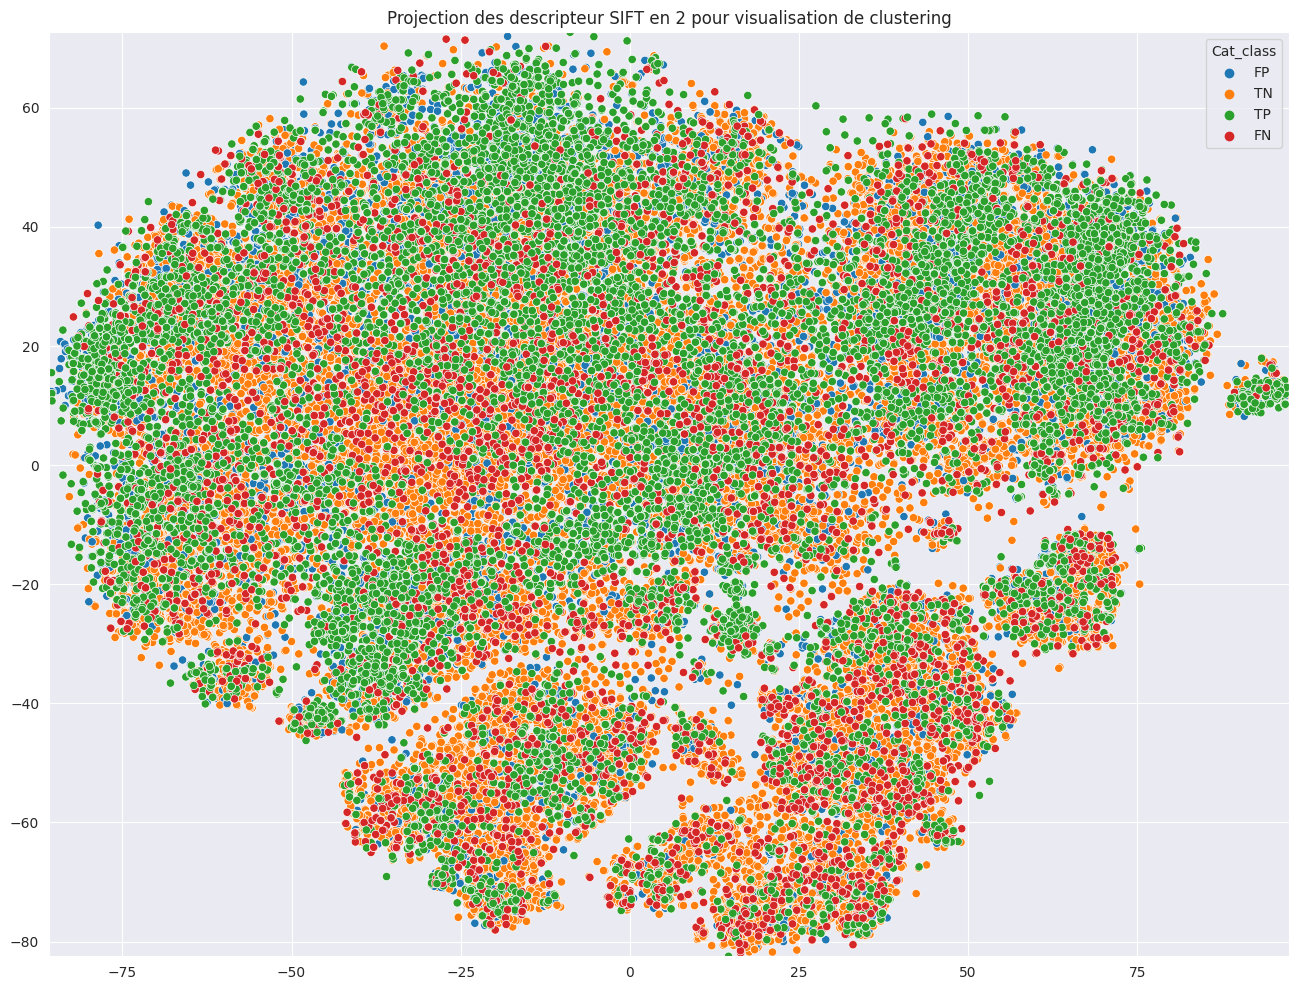

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=df_synthese['Cat_class'])

# On redéfinit les axes pour bien voir tous les points
plt.xlim([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])])
plt.ylim([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])])

plt.title(f"Projection des descripteur SIFT en 2 pour visualisation de clustering")

# On affiche l'image
plt.show()

# Optimisation RegLog

GridSearch avec regularisation & Solver
Scaler : passage de MinMax a Standard

In [26]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(class_weight='balanced', max_iter=200)

pipeline = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

params = {
    'estimator__penalty' : ['l1', 'l2', 'elasticnet'],
    'estimator__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
}

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=200))]),
             param_grid={'estimator__penalty': ['l1', 'l2', 'elasticnet'],
                         'estimator__solver': ['lbfgs', 'liblinear',
                                               'newton-cg',
                                               'newton-cholesky']},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [27]:
print("Best params : ", model.best_params_)
print("Best score : ", model.best_score_ )

Best params :  {'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
Best score :  0.43695006642120376


In [28]:
estimator = LogisticRegression(class_weight='balanced', max_iter=200, penalty='l2', solver='lbfgs')

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

 TRAIN F2 score model :  0.4433518720256866


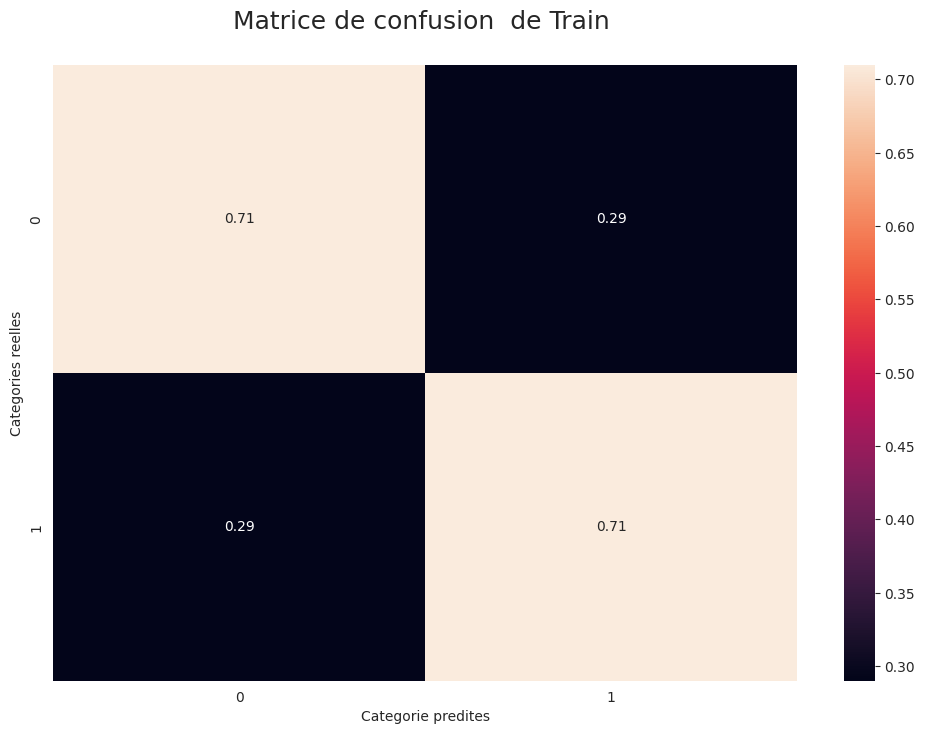

F2 score model 1 :  0.4386597160529006


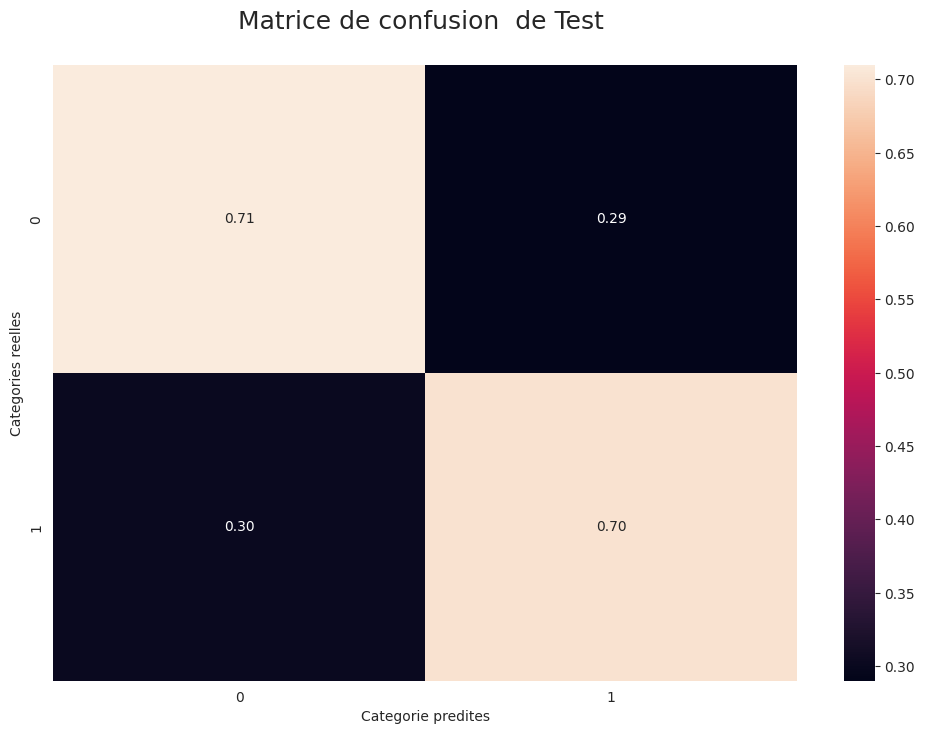

In [29]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = gu810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = gu810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [33]:
df_synthese = X_test
df_synthese.loc[:,"TARGET"] = y_test
df_synthese.loc[:, "Y_PRED"] = y_pred
df_synthese

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CURRENT_TO_APPROVED_CREDIT_MAX_RATIO,CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO,CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,TARGET,Y_PRED
199279,199284.0,331040.0,1.0,0.0,247500.0,454500.0,21190.5,454500.0,0.026398,-23456.0,...,0.642090,0.359131,1.146484,0.593750,0.902344,0.635254,0.058807,NaN,0.0,0.0
122966,122970.0,242584.0,1.0,0.0,58500.0,312768.0,13378.5,270000.0,0.018799,-23168.0,...,0.124695,0.092834,0.581055,0.364258,0.385010,0.258301,0.083130,NaN,0.0,0.0
156663,156667.0,281587.0,0.0,0.0,180000.0,720000.0,28683.0,720000.0,0.014465,-12120.0,...,0.212646,0.138794,0.561523,0.327637,0.796875,0.512695,0.092590,0.353271,0.0,1.0
134381,134385.0,255868.0,1.0,0.0,112500.0,288873.0,16713.0,238500.0,0.018845,-20848.0,...,0.229004,0.199951,0.841309,0.615234,0.588379,0.395752,0.072449,NaN,0.0,0.0
250107,250112.0,389383.0,0.0,1.0,270000.0,500211.0,34056.0,463500.0,0.046234,-16672.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111420,111424.0,229282.0,0.0,1.0,180000.0,405000.0,20808.0,405000.0,0.031342,-9608.0,...,0.872070,0.292725,1.873047,0.630371,1.027344,0.559082,0.085815,1.096680,0.0,1.0
197893,197898.0,329448.0,1.0,1.0,256500.0,1687266.0,64395.0,1575000.0,0.011703,-14728.0,...,0.063660,0.047424,0.173096,0.137329,0.372314,0.339600,0.049988,0.107178,0.0,0.0
226756,226761.0,362656.0,0.0,0.0,202500.0,1006920.0,40063.5,900000.0,0.006008,-15408.0,...,0.088867,0.070374,0.413086,0.278076,0.795898,0.407715,0.025833,0.300293,0.0,0.0
194536,194541.0,325577.0,0.0,0.0,180000.0,312768.0,13905.0,270000.0,0.007275,-22432.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [34]:
df_synthese.to_csv('./model_outputs/BEST_REGLOG_TEST_RESULTS.csv')

# SAVE BEST MODEL IN MLFLOW REGISTRY

In [6]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(class_weight='balanced', max_iter=200, penalty='l2', solver='lbfgs')

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

/home/maximorose/anaconda3/envs/oc_ds_p7/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


 TRAIN F2 score model :  0.4433518720256866


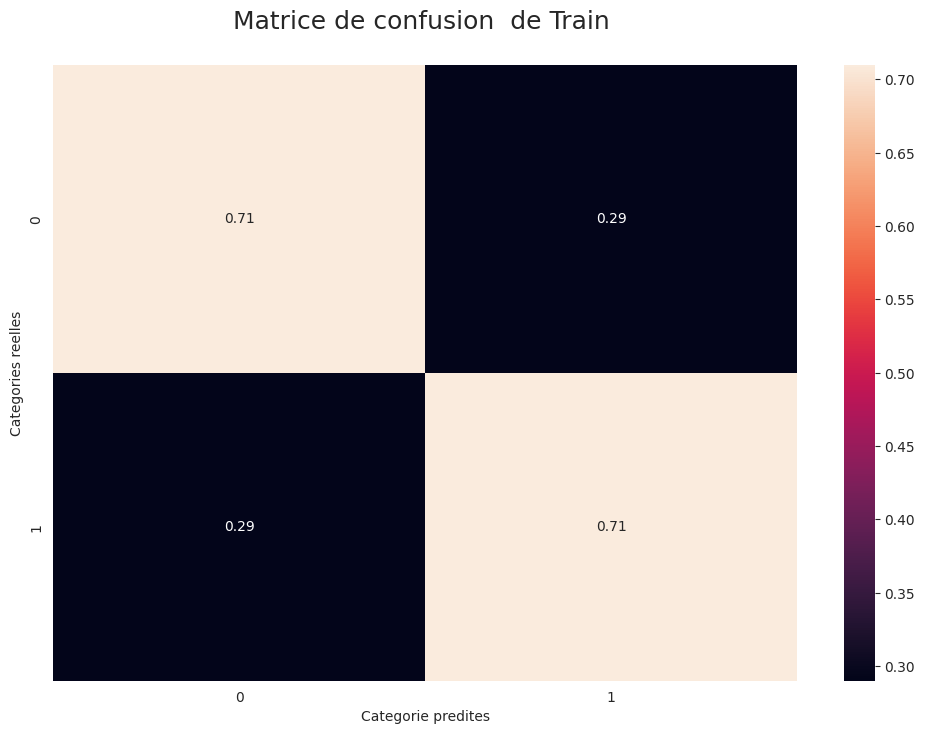

F2 score model 1 :  0.4386597160529006


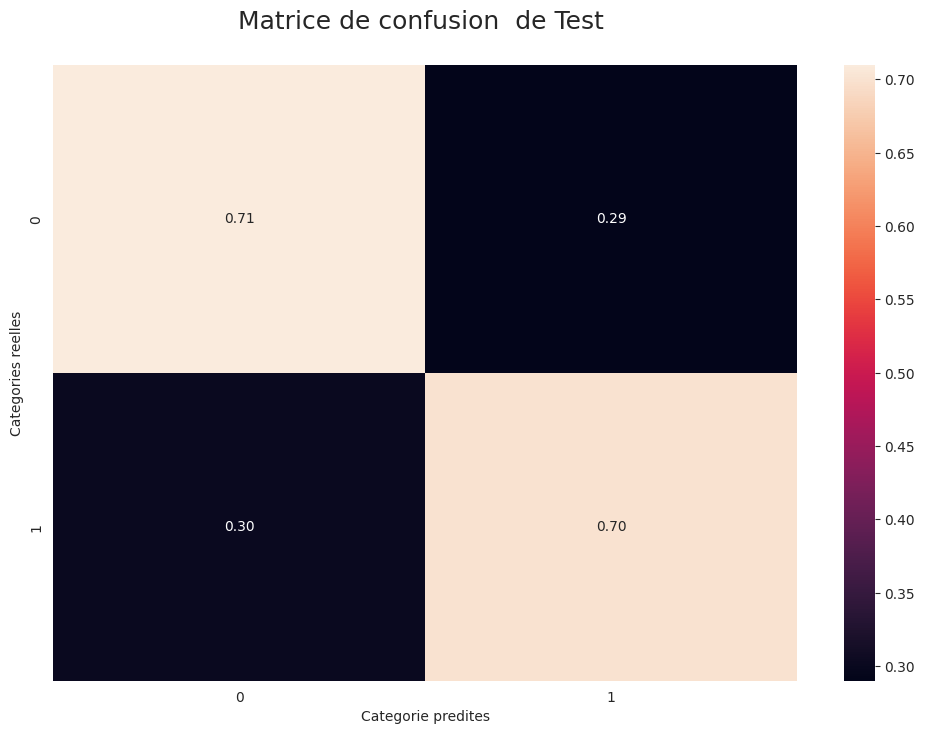

In [7]:
df_xtrain = pd.DataFrame(X_train, columns=X.columns)

with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = gu810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = gu810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

# TEST FE - OC REF

In [11]:
fe_filename = 'OCkernel_customized.csv'

In [8]:
df = pd.read_csv(INPUT_FOLDER+fe_filename)
df = ckk.reduce_memory(df)
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

X = train_df.drop(columns = ['TARGET'])
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Initial df memory usage is 1720.48 MB for 633 columns
Final memory usage is: 531.70 MB - decreased by 69.1%
Train shape: (307507, 633), test shape: (48744, 633)
X_train : (215254, 632) // X_test : (92253, 632)
y_train : (215254,) // y_test : (92253,)


In [9]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(class_weight='balanced', max_iter=200, penalty='l2', solver='lbfgs')

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

/home/maximorose/.local/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 TRAIN F2 score model :  0.4389784293851447


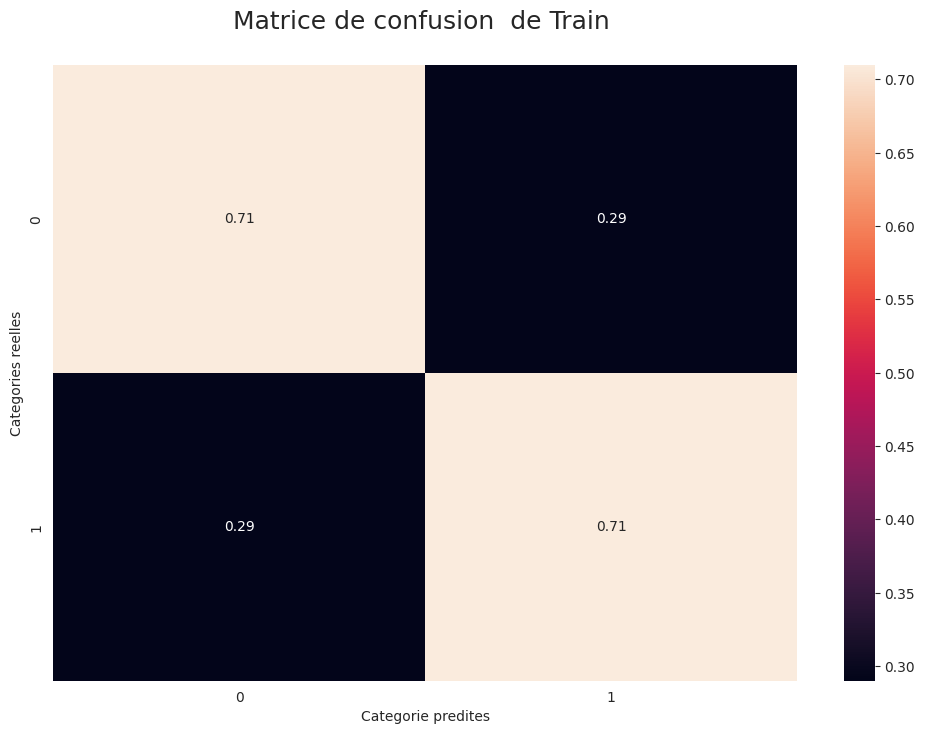

F2 score model 1 :  0.43451060209205716


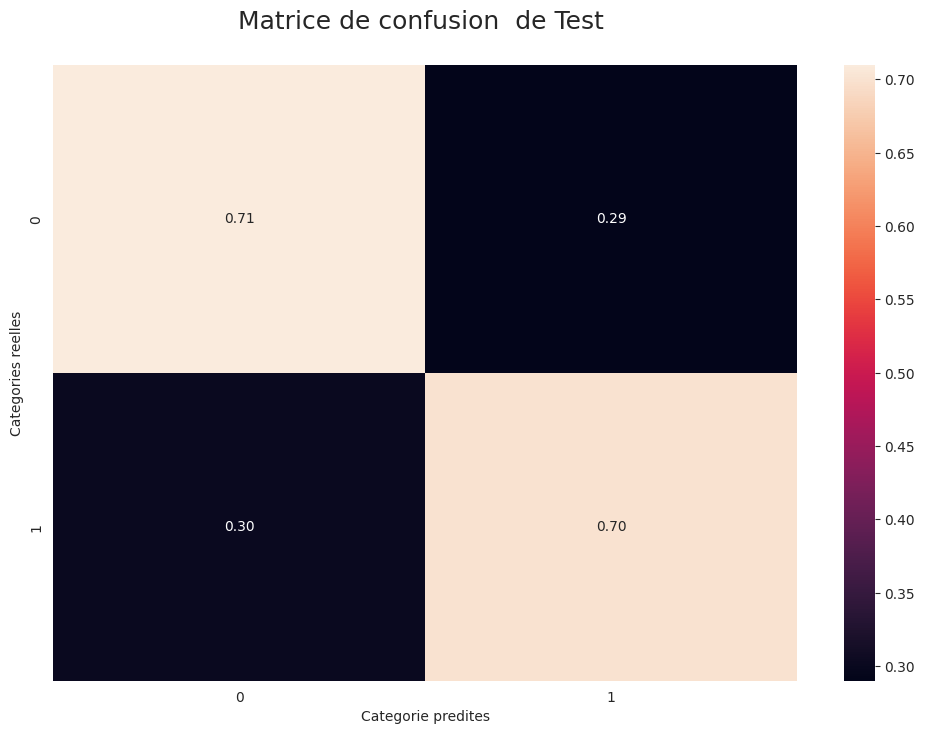

In [13]:
df_xtrain = pd.DataFrame(X_train, columns=X.columns)

with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = gu810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = gu810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [ ]:
model['estimator'].coef_

# SPLITTED TRAIN & TEST FOR PREPROCESSING

In [11]:
fe_filename = 'kernel03_install_payments_Train_Only.csv'

In [3]:
df = pd.read_csv(INPUT_FOLDER+fe_filename)
df = ckk.reduce_memory(df)

X = df.drop(columns = ['TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Initial df memory usage is 1252.81 MB for 534 columns
Final memory usage is: 409.39 MB - decreased by 67.3%
X_train : (215254, 533) // X_test : (92253, 533)
y_train : (215254,) // y_test : (92253,)


In [5]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(class_weight='balanced', max_iter=200, penalty='l2', solver='lbfgs')

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

 TRAIN F2 score model :  0.4443073568231378


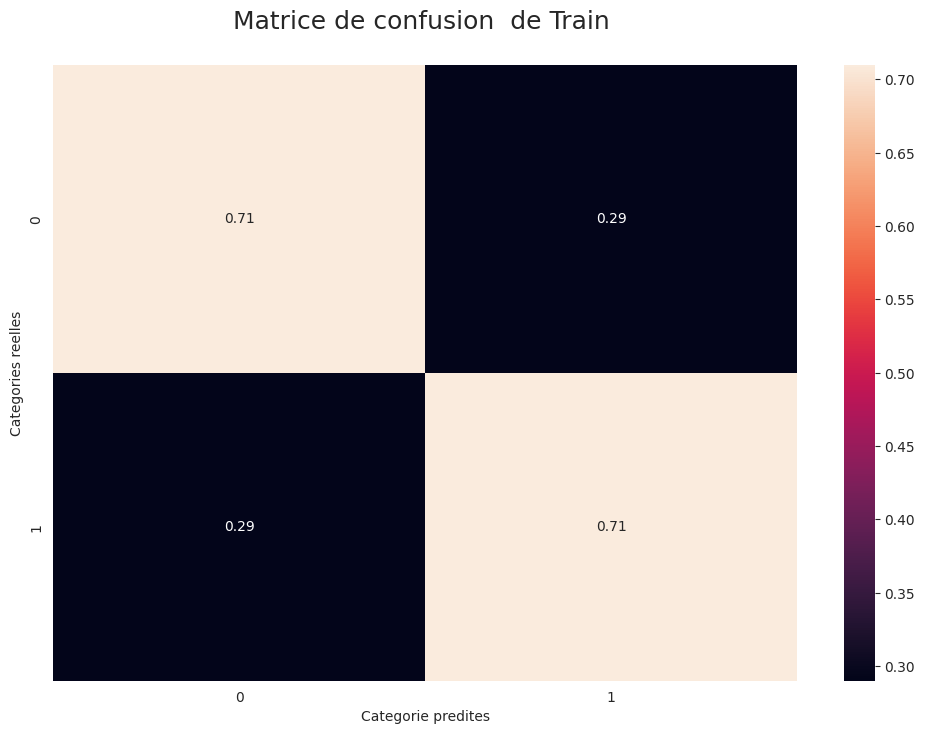

F2 score model 1 :  0.442283510772068


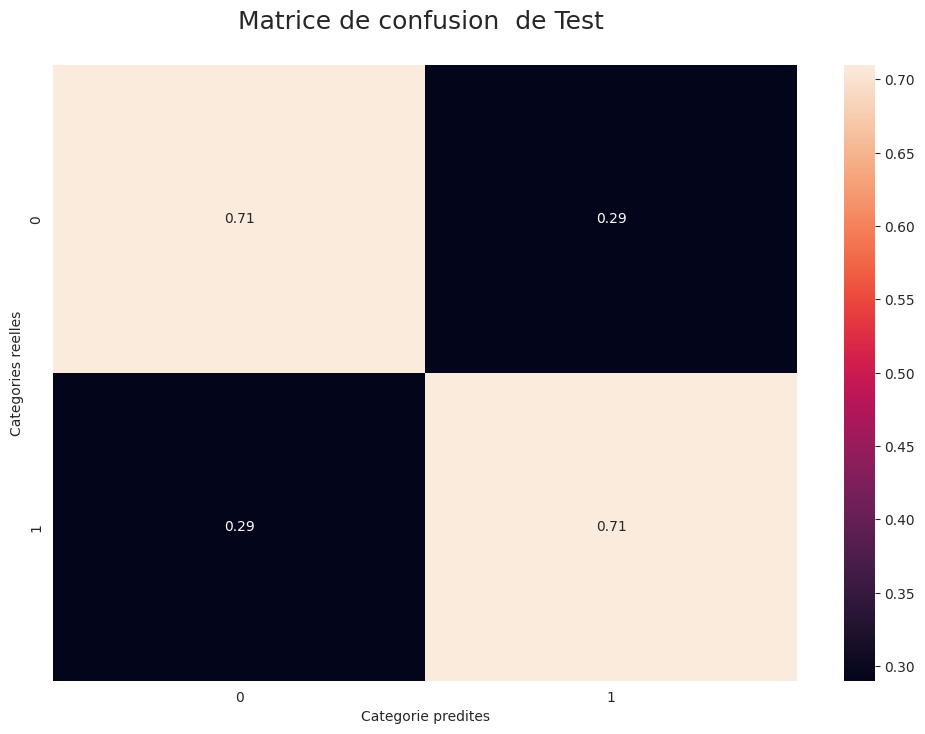

In [12]:
with mlflow.start_run():
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = gu810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = gu810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [13]:
model['estimator'].coef_

array([[ 2.39168183e-03, -1.89166731e-01, -1.21875058e-01,
         7.46360320e-01,  6.29828081e-01,  4.59050387e-02,
        -6.33736812e-01,  2.50934282e-02,  1.84686510e-01,
         1.14703259e-01,  2.89064246e-02,  8.47875058e-02,
         8.26029027e-02,  7.72172035e-02, -4.25172561e-02,
         1.34014941e-01, -1.12616102e-02,  3.75409503e-02,
        -1.02700786e-02, -1.78957598e-01, -3.88639567e-01,
        -3.74378722e-01,  8.99523090e-02, -2.97125122e-01,
         4.67817339e-02,  1.76418092e-02, -4.78546924e-02,
         4.02992872e-02, -2.76923163e-02, -7.38968331e-03,
         2.61186753e-01, -1.46386414e-01,  2.91226617e-02,
         7.30176367e-02, -3.50025351e-03, -5.70864393e-02,
         3.45120260e-02, -2.80544907e-02, -3.64764548e-03,
         2.40288365e-03, -2.28803094e-02, -3.59616389e-02,
         4.53006596e-02, -1.03614360e-01,  3.24507899e-02,
         6.61894428e-02, -3.26272031e-02, -1.60332719e-02,
         6.47666663e-01, -4.72152193e-02, -1.28102983e-0

In [19]:
coefficients = model['estimator'].coef_[0]
feature_names = np.array(X.columns.tolist())

In [20]:
len(feature_names)

533

In [21]:
# Sort coefficients in descending order and get the 40 largest coefficients
top40_coefficients = np.argsort(np.abs(coefficients))[::-1][:40]

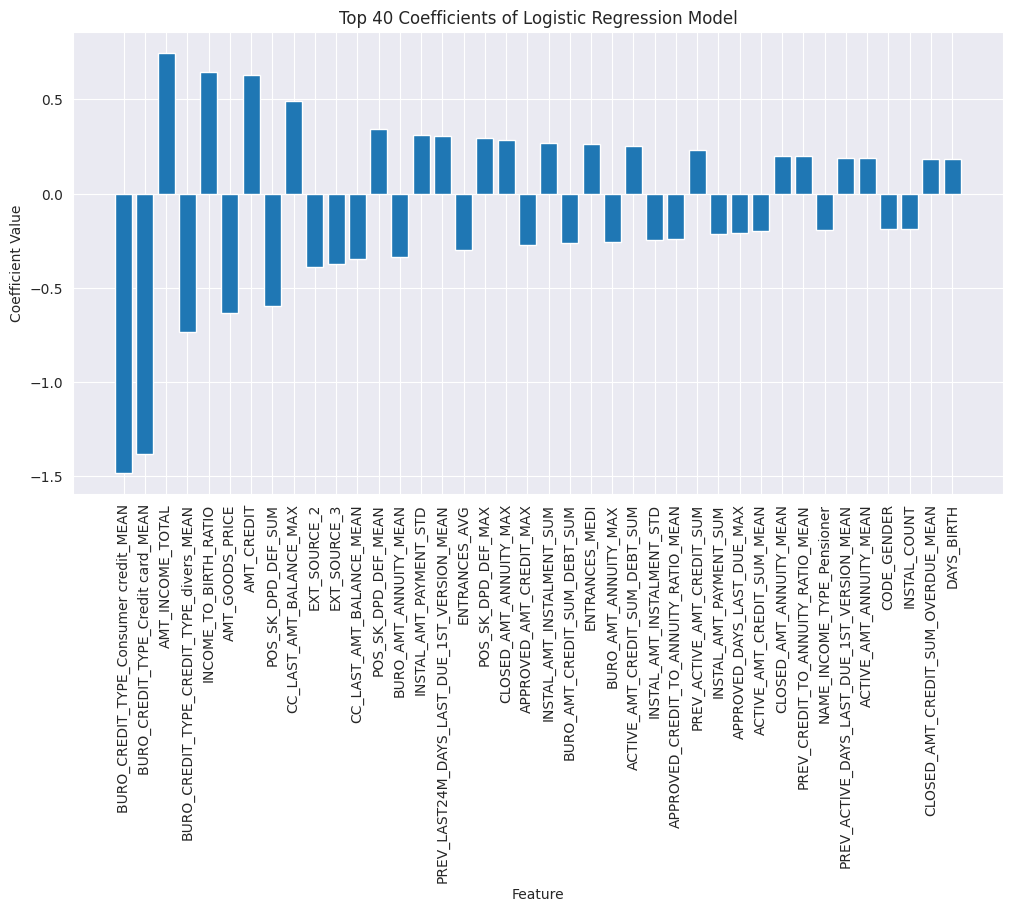

In [22]:
import matplotlib.pyplot as plt

# Plot the values of the selected coefficients
plt.figure(figsize=(12, 6))
plt.bar(range(len(top40_coefficients)), coefficients[top40_coefficients])
plt.xticks(range(len(top40_coefficients)), feature_names[top40_coefficients], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Top 40 Coefficients of Logistic Regression Model')
plt.show()

In [23]:
LogReg_Top40_coeff = feature_names[top40_coefficients]
LogReg_Top40_coeff

array(['BURO_CREDIT_TYPE_Consumer credit_MEAN',
       'BURO_CREDIT_TYPE_Credit card_MEAN', 'AMT_INCOME_TOTAL',
       'BURO_CREDIT_TYPE_CREDIT_TYPE_divers_MEAN',
       'INCOME_TO_BIRTH_RATIO', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'POS_SK_DPD_DEF_SUM', 'CC_LAST_AMT_BALANCE_MAX', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'CC_LAST_AMT_BALANCE_MEAN', 'POS_SK_DPD_DEF_MEAN',
       'BURO_AMT_ANNUITY_MEAN', 'INSTAL_AMT_PAYMENT_STD',
       'PREV_LAST24M_DAYS_LAST_DUE_1ST_VERSION_MEAN', 'ENTRANCES_AVG',
       'POS_SK_DPD_DEF_MAX', 'CLOSED_AMT_ANNUITY_MAX',
       'APPROVED_AMT_CREDIT_MAX', 'INSTAL_AMT_INSTALMENT_SUM',
       'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'ENTRANCES_MEDI',
       'BURO_AMT_ANNUITY_MAX', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
       'INSTAL_AMT_INSTALMENT_STD',
       'APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN',
       'PREV_ACTIVE_AMT_CREDIT_SUM', 'INSTAL_AMT_PAYMENT_SUM',
       'APPROVED_DAYS_LAST_DUE_MAX', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       'CLOSED_AMT_ANNUITY_MEAN', 'PREV_CRE

In [25]:
df_logReg = pd.DataFrame(LogReg_Top40_coeff, columns=['feature'])
df_logReg.loc[:, 'LogRegImportance'] = df_logReg.index + 1

In [28]:
df_logReg.to_csv('./model_outputs/feature_importance.csv', index=False)